# ——  基于电商产品评论数据情感分析  ——

### 1.案例简介

    1、利用文本挖掘技术，对碎片化、非结构化的电商网站评论数据进行清洗与处理，转化为结构化数据。
    2、参考知网发布的情感分析用词语集，统计评论数据的正负情感指数，然后进行情感分析,通过词云图直观查看正负评论的关键词。
    3、比较“机器挖掘的正负情感”与“人工打标签的正负情感”，精度达到88%。
    4、采用LDA主题模型提取评论关键信息，以了解用户的需求、意见、购买原因、产品的优缺点等。
 

### 2.框架

    工具准备
    
    一、导入数据
    二、数据预处理
        （一）去重
        （二）数据清洗
        （三）分词、词性标注、去除停用词、词云图
    三、模型构建
        （一）决策树
        （二）情感分析
        （三）基于LDA模型的主题分析

## 工具准备

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import style #自定义图表风格
style.use('ggplot')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #显示多行输出结果
plt.rcParams['font.sans-serif'] = ['Simhei'] # 解决中文乱码问题 运行配置参数中的字体（font）为黑体（SimHei）

import re
import jieba.posseg as psg 
import itertools
#conda install -c anaconda gensim
from gensim import corpora,models #主题挖掘，提取关键信息

# pip install wordcloud
from wordcloud import WordCloud,ImageColorGenerator
from collections import Counter

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import graphviz
os.environ["PATH"] += os.pathsep + 'G:\WEB\Graphviz\bin/'

from PIL import Image
import pymongo
import json
from sklearn.datasets import load_iris
import pyLDAvis
import pyLDAvis.gensim_models  as gensimvis
import warnings
warnings.filterwarnings("ignore")



# python:https://docs.python.org/zh-cn/3/ https://docs.python.org/zh-cn/3/contents.html
# pandas:https://pandas.pydata.org/docs/reference/index.html
# re:https://docs.python.org/zh-cn/3/library/re.html#module-re https://www.cnblogs.com/susan-su/p/10820930.html
# requests https://requests.readthedocs.io/en/latest/
# jieba: https://github.com/fxsjy/jieba
# matplotlib.pyplot: https://matplotlib.org/stable/api/pyplot_summary.html
# PIL:https://pillow.readthedocs.io/en/stable/reference/Image.html
# sklearn:https://scikit-learn.org/stable/

## 爬取数据

In [ ]:
import requests
import csv
import xlwt
import re
import sys
import webbrowser
import time
import random

# web_url = https://detail.tmall.com/item.htm?spm=a220m.1000858.1000725.1.5a9129c4qKAGfo&id=619210569446
# https://www.httpbin.org/ip
# https://requests.readthedocs.io/en/latest/

PAGE_URL = []
data = []

def start_pyretile():
    num = 90
    try:
        Get_Url(num)
        datalist = GetInfo(num)
        # savepath_xls = "reviews_Midea_new.xls"
        savepath_csv = 'reviews_Media.csv'
        # Save_Data_xls(datalist, savepath_xls)
        Save_Data_csv(datalist, savepath_csv)
        # Save_Data_xls(data, "temp.xls")
        Save_Data_csv(data, "reviews_temp.csv")
    except Exception as e:
        print(e)
        # Save_Data_xls(data, "temp.xls")
        Save_Data_csv(data, "reviews_temp.csv")




# def Open_Url(url):
#     print(url)
    # 浏览器运行目录
    # chromePath = r"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe"
    # # 注册浏览器
    # webbrowser.register('chrome', None, webbrowser.BackgroundBrowser(chromePath))
    # # 获取浏览器并打开指定地址
    # webbrowser.get('chrome').open(url, new=2, autoraise=True)



def Get_Url(num):
    urlfirst = "https://rate.tmall.com/list_detail_rate.htm?itemId=619210569446&spuId=1683875765&sellerId=1595477379&order=3&currentPage="
    urllast = "&append=1&content=1&tagId=&posi=&picture=0&groupId=&ua=098%23E1hvQvvWvRyvUpCkvvvvvjiWRLdvsjYRPsspgjivPmPpsjDCRFLUzjnjnLqhsjtPRIvCvCB4cW79Tn147Di6HRwwGxKo75MNh4QCvvDvpSDyd9Cv7E7VvpvhphhvvvvCvvXvppvvvvvUvpCWpVu9v8WfjLB%2Bm7zOdigrvsCNQ4mZHkx%2FJoL6D46OjZODNr3ld3ODN5OdYU9uh7QEVAdvaXTAVA%2BaBixrVTgaWox%2F0j7JSL9mEcqZaO9CvvXmp99h5EuIvpvUphvhC%2BeiR9KgvpvIphvvvvvvphCvpv1xvvCmsZCvHHyvvhn2phvZ7pvvpiivpCBXvvCme9gCvvpvvPMMRvhvChCvvvmevpvhphvhH29CvvBvpvvv&itemPropertyId=&itemPropertyIndex=&userPropertyId=&userPropertyIndex=&rateQuery=&location=&needFold=0&_ksTS=1656034137355_1706&callback=jsonp1707"
    for i in range(55,num):
        PAGE_URL.append(urlfirst+str(i+1)+urllast)

def GetInfo(num):
    datalist = []
    referenceName = "美的空调1.5匹一级能效变频挂机冷暖两用除湿抽湿自清洁酷金ZHA"
    time_num = 0
    for i in range(0,35):
        headers = {
            'authority':'rate.tmall.com',
            'scheme':'https',
            'accept':'*/*',
            'accept-encoding':'gzip, deflate, br',
            'accept-language':'zh-CN,zh;q=0.9',
            'cookie': 'lid=tb589358954137; cna=bG5ZGtdBAVECAdpYpB1T8Cow; enc=5W6jTcnreGiNQR2nyhCEG%2BF53QHDrWaoeX6gl6Cc7VhZAf%2FaQ%2FKPZ2Ao%2FwSjO5VTRKK4sMed2n8Wm0MySfeEovhoZvQVS1PH0preARGvixk%3D; Hm_lvt_eaa57ca47dacb4ad4f5a257001a3457c=1655863806; _m_h5_tk=d6251357e64e26090ddbc94159f0c362_1655903559667; _m_h5_tk_enc=8456233574731a1e4bf0e60ea7522870; sgcookie=E100Yq7uWnTn3aOckG4dGs7FPogmiFOseeiV7YnNIUQirhohExgdxJj8pGHH6NACoZy1MFc3qg9Fb9r0DMF775TJtEOt4XuNIaciCiIgED1EUB4%3D; uc3=lg2=WqG3DMC9VAQiUQ%3D%3D&id2=UUpgQhI2muZHKHRnQw%3D%3D&nk2=F5RASpbbX7%2Fah0d%2FxpM%3D&vt3=F8dCvCIUD8%2Fnc3uqyEo%3D; t=ac6d2e7fb32ae29087d7126043c14133; tracknick=tb589358954137; uc4=nk4=0%40FY4L5jxo5hRGAIIzHbwpD64iOe%2Bk8Dmw8g%3D%3D&id4=0%40U2gqzcKx6qAhk8uxmKxp6yn2BJRcuHyL; lgc=tb589358954137; _tb_token_=f5b1656463148; cookie2=18383bb083526518e1d53be76fa73feb; xlly_s=1; tfstk=cP55Be6VZ0m72zyEaaa4Un60JPvdawhXojxVPoBHheNjORIvDs0K_hsZLUiXTeLf.; l=eBEOR0DnLG39v0KXBO5aKurza77OCCOfclVzaNbMiIncC6iRdy9MT9xQ0LXFDCtRR8XcGQLp4dXYTPyTgF3z-y8foTB7K9cdvdUwCef..; isg=BKOjhG7PxT9yBYkMoaww1stoMudNmDfa12dWV9UFkoCHFMs2XGp6K9ECDuQaj4_S',
            'referer':'https://detail.tmall.com/item.htm?spm=a220m.1000858.1000725.1.1d4e29c4NVr33W&id=619210569446&skuId=4546747751124&areaId=511300&user_id=1595477379&cat_id=2&is_b=1&rn=a1bb3c7fbcd94dc737e420c2d0d783ab',
            'user-agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36'
        }
        item = requests.get(PAGE_URL[i],headers = headers).text
        try:
            validate = re.findall('"url":"(.*?)"',item)[0]
            if (len(validate) != 0):
                print("访问被拒绝")
                print(validate)
                return datalist
                    # time.sleep(1200)
                    # item = requests.get(PAGE_URL[i], headers=headers).text
                    # validate = re.findall('"url": "(.*?)"', item)[0]
        except Exception as e:
            print("正在爬取第"+ str(i+1) + "页" )
        try:
            validate_two = re.findall('"url": "(.*?)"',item)[0]
            if (len(validate_two) != 0):
                print("检测到需要进行机器验证")
                print(validate_two)
                return datalist
                    # time.sleep(1200)
                    # item = requests.get(PAGE_URL[i], headers=headers).text
                    # validate = re.findall('"url": "(.*?)"', item)[0]
        except Exception as e:
            print("验证通过 耗时" + str(time_num) + "秒")
        content = re.findall('"content":"(.*?)"', item)
        creationTime = re.findall('"rateDate":"(.*?)"', item)
        nickname = re.findall('"displayUserNick":"(.*?)"', item)
        content_type = re.findall('"anony":(.*?),',item)
        for j in range(0,len(content)):
            temp = [content[j],creationTime[j],nickname[j],referenceName,content_type[j]]
            datalist.append(temp)
            data.append(temp)
        # time.sleep(5)
        if (i % 10 == 0):
            time_num = random.randint(20, 30)
            time.sleep(time_num)
        else:
            time_num = random.randint(45, 65)
            time.sleep(time_num)
    return datalist

def Save_Data_xls(datalist,savepath):
    book = xlwt.Workbook(encoding="utf-8", style_compression=0)
    sheet = book.add_sheet("美的洗衣机用户评论", cell_overwrite_ok=True)
    col = ("content", "creationTime", "nickname", "referenceName", "content_type")
    for i in range(0, 5):
        sheet.write(0, i, col[i])
    for i in range(0, len(datalist)):
        data = datalist[i]
        for j in range(0, 5):
            sheet.write(i + 1, j, data[j])
    book.save(savepath)

def Save_Data_csv(datalist,savepath):
    header = ['content', 'creationTime', 'nickname', 'referenceName' ,'content_type']
    with open(savepath, 'w', encoding='utf-8',newline='') as file_obj:
        writer = csv.writer(file_obj)
        writer.writerow(header)
        for data in datalist:
            writer.writerow(data)


if __name__ == '__main__':
    start_pyretile()


        # print(dk)


 # urlfirst = "https://rate.tmall.com/list_detail_rate.htm?itemId=619210569446&spuId=1683875765&sellerId=1595477379&order=3&currentPage="
 #    urllast = "&append=0&content=1&tagId=&posi=&picture=&groupId=&ua=098%23E1hvDpvPvBvvUvCkvvvvvjiWRL5yQj3WRFdZ1jEUPmPWgjDUPFspgj3UP25U1j38dvhvmpvCLZekvvmE1uQCvvyv9PMqnQvvk2%2BgvpvhvvCvpUvCvCLwMR1JBrMwznAYtlS5ON1Azvx44UOCvvpv9hCvRvhvCvvvphmIvpvUvvCCQmge7IAUvpvVvpCmp%2FLZKvhv8vvvphvvvvvvvvChovvvvwwvvhZLvvmCvvvvBBWvvvH%2BvvCHhQvvv7QUvpCWv7j%2BqCzv5fVQKoZH1WQaRfUTnZJt9b8reCIaB%2BCl5d8rVBlVD70XdugZEcqhaXp7%2Bul1Bcc6RqJ6WeCp%2BE7reCuKNB3rg8g7%2BulAbQvCvvOv9hCvvvvRvpvhvv2MMTOCvvpvvhHhdvhvmpmv%2FMFFvvmmGuQCvvyv9PNsuvvv3dI%3D&needFold=0&_ksTS=1655903471784_524&callback=jsonp525"
 #    for i in range(98,num):
# 'cookie': 'lid=tb589358954137; cna=bG5ZGtdBAVECAdpYpB1T8Cow; xlly_s=1; enc=5W6jTcnreGiNQR2nyhCEG%2BF53QHDrWaoeX6gl6Cc7VhZAf%2FaQ%2FKPZ2Ao%2FwSjO5VTRKK4sMed2n8Wm0MySfeEovhoZvQVS1PH0preARGvixk%3D; Hm_lvt_eaa57ca47dacb4ad4f5a257001a3457c=1655863806; _m_h5_tk=d6251357e64e26090ddbc94159f0c362_1655903559667; _m_h5_tk_enc=8456233574731a1e4bf0e60ea7522870; sgcookie=E100Yq7uWnTn3aOckG4dGs7FPogmiFOseeiV7YnNIUQirhohExgdxJj8pGHH6NACoZy1MFc3qg9Fb9r0DMF775TJtEOt4XuNIaciCiIgED1EUB4%3D; uc3=lg2=WqG3DMC9VAQiUQ%3D%3D&id2=UUpgQhI2muZHKHRnQw%3D%3D&nk2=F5RASpbbX7%2Fah0d%2FxpM%3D&vt3=F8dCvCIUD8%2Fnc3uqyEo%3D; t=3cd4be0d0c66c5c09021f406f737af23; tracknick=tb589358954137; uc4=nk4=0%40FY4L5jxo5hRGAIIzHbwpD64iOe%2Bk8Dmw8g%3D%3D&id4=0%40U2gqzcKx6qAhk8uxmKxp6yn2BJRcuHyL; lgc=tb589358954137; _tb_token_=e819e56383a41; cookie2=1e9c79371f8d91b6c2b26dbc65dbb9bd; x5sec=7b22617365727665723b32223a22626666336530323435356131303764636262633136306430663264356531653343494f707a4a5547454d61696a5a336c6e62505635414561447a49794d5451794e5451304f5441324e4441374e6967434d4b366838593043227d; tfstk=cgnABe9yGQAmhf2-LqLubC-DhLuOZJYYsQVFXcsHCCIpCRjOiUmnv8ZFqJFUMLC..; l=eBEOR0DnLG39vEFwBO5Bourza7792IRb8oVzaNbMiInca66dsemVvNChogq2-dtjgtff4etyItFU7R3W-RaU-K_ceTwhKXIpB0v9-; isg=BF1dbv48408fsYdi607WAPGqbDlXepHMPeXY-R8iLLTS1nwI58vrnZRAAMpQEqmE',
# 'referer': 'https://detail.tmall.com/item.htm?spm=a220m.1000858.1000725.1.5a9129c4qKAGfo&id=619210569446',

正在爬取第1页
验证通过 耗时0秒
正在爬取第2页
验证通过 耗时23秒
正在爬取第3页
验证通过 耗时48秒
正在爬取第4页
验证通过 耗时52秒
正在爬取第5页
验证通过 耗时45秒


#### 注意

    以下方法，是为了帮助我们直观查看对象处理的结果。是辅助代码，非必要代码！
    .head()
    print()
    len()
    .shape
    .unique()

## 一、导入数据

In [2]:
raw_data=pd.read_csv('G:\\work\\testdata\\reviews_midea.csv')
raw_data.head()

,content,creationTime,nickname,referenceName,content_type
0,家里一直都是买的美的空调，质量有保障，外观好看，安装服务好，细心想办法解决问题，为客户着想，...,2022-06-14 23:32:50,t***3,美的空调1.5匹一级能效变频挂机冷暖两用除湿抽湿自清洁酷金ZHA,pos
1,此用户没有填写评论!,2022-06-12 18:54:43,堤***岸,美的空调1.5匹一级能效变频挂机冷暖两用除湿抽湿自清洁酷金ZHA,pos
2,家里一共买了四台美的的空调，效果不错，制冷很快，运行声音也不大。可以手机操控，不用遥控器，家...,2022-06-16 22:21:38,a***5,美的空调1.5匹一级能效变频挂机冷暖两用除湿抽湿自清洁酷金ZHA,pos
3,美的送货小哥服务到位，大热天提前电话预约，准时送达，一口气背上三楼，服务相当的哇塞。空调美观...,2022-06-19 07:29:43,y***7,美的空调1.5匹一级能效变频挂机冷暖两用除湿抽湿自清洁酷金ZHA,pos
4,功率大小：目前还没有长时间大量用，期待好用， 样子挺好看的，金色字，挺高大上的，性价比可以～...,2022-06-19 16:45:30,大***忆,美的空调1.5匹一级能效变频挂机冷暖两用除湿抽湿自清洁酷金ZHA,pos


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4923 entries, 0 to 4922
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        4923 non-null   object
 1   creationTime   4923 non-null   object
 2   nickname       4923 non-null   object
 3   referenceName  4923 non-null   object
 4   content_type   4923 non-null   object
dtypes: object(5)
memory usage: 192.4+ KB


In [4]:
raw_data.columns

Index(['content', 'creationTime', 'nickname', 'referenceName', 'content_type'], dtype='object')

In [5]:
#取值分布
for cate in ['creationTime', 'nickname', 'referenceName', 'content_type']:
    raw_data[cate].value_counts() #返回一些最常出现的行

2022-01-04 17:49:05    4
2022-04-28 19:07:08    4
2022-02-15 13:20:37    4
2022-06-04 12:14:04    4
2022-06-05 12:08:59    3
                      ..
2022-06-23 12:49:18    1
2022-06-23 12:29:43    1
2022-06-23 12:29:26    1
2022-06-23 12:16:01    1
2021-07-01 12:39:32    1
Name: creationTime, Length: 4058, dtype: int64

t***1    110
t***2    104
t***0     93
t***7     90
t***8     89
        ... 
灰***8      1
翼***5      1
希***9      1
吴***5      1
z***东      1
Name: nickname, Length: 2405, dtype: int64

美的空调1.5匹一级能效变频挂机冷暖两用除湿抽湿自清洁酷金ZHA    4923
Name: referenceName, dtype: int64

pos    4680
neg     243
Name: content_type, dtype: int64

## 二、数据预处理

### （一）去重

删除系统自动为客户做出的评论。

In [6]:
reviews=raw_data.copy()
reviews=reviews[['content', 'content_type']]
print('去重之前：',reviews.shape[0])  
reviews=reviews.drop_duplicates(ignore_index = True)  #If True, the resulting axis will be labeled 0, 1, …, n - 1. keep{‘first’, ‘last’, False}, default ‘first’
print('去重之后：',reviews.shape[0])

去重之前： 4923
去重之后： 3359


### （二）数据清洗

In [7]:
# 清洗之前
content=reviews['content']
content.head(10)

0    家里一直都是买的美的空调，质量有保障，外观好看，安装服务好，细心想办法解决问题，为客户着想，...
1                                           此用户没有填写评论!
2    家里一共买了四台美的的空调，效果不错，制冷很快，运行声音也不大。可以手机操控，不用遥控器，家...
3    美的送货小哥服务到位，大热天提前电话预约，准时送达，一口气背上三楼，服务相当的哇塞。空调美观...
4    功率大小：目前还没有长时间大量用，期待好用， 样子挺好看的，金色字，挺高大上的，性价比可以～...
5    制冷效果非常棒，几分钟这个房间都清凉了关键一级能效好太多了，省电呀。 机子无任何噪音，安装师...
6    功率大小：使用方便，一级能效，功能齐全，外观漂亮，特别是那个金色弧度，犹如财源滚滚来，看着也...
7    安装师傅很好，安装好还把垃圾弄好，装的很仔细，这个用起来制冷很快非常好，家里洗衣机也是美的的...
8              美的空调确实不错，声音很小，冷速度很快，安装师傅也很给力，一个小时左右就装好了
9    空调收到了，物流很快外包装没有任何破损，其次安装师傅服务很好，安装问题及建议很周到，不错的一...
Name: content, dtype: object

In [8]:
#清洗之后，将数字、字母、京东美的电热水器字样都删除
info=re.compile('[0-9a-zA-Z]|淘宝|美的|空调|酷金|此用户没有填写评论!|')
# info=re.compile('[0-9a-zA-Z]|淘宝|美的|空调|师傅|酷金|安装|卖家|物流|售后|服务|送货|功率|产品|客服|商品|此用户没有填写评论!|客户|家里|效果|制冷|制热|质量|态度|声音|价格|购物|品牌|外观|速度|下单|小哥|发货|快递|人员|价格|技术|购买|购物|操作|活动|包装|洗衣机|建议')
content=content.apply(lambda x: info.sub('',x))  #替换所有匹配项
content=content.replace('',np.nan)  #Empty strings are not considered NA values. None is considered an NA value.
content=content.dropna().reset_index(drop=True)
content.head(10)
content.to_csv(r'G:\work\testdata\temp.csv',sep=',',index=False,header='content')

0    家里一直都是买的，质量有保障，外观好看，安装服务好，细心想办法解决问题，为客户着想，提供了最...
1    家里一共买了四台的，效果不错，制冷很快，运行声音也不大。可以手机操控，不用遥控器，家里有小宝...
2    送货小哥服务到位，大热天提前电话预约，准时送达，一口气背上三楼，服务相当的哇塞。美观上档次，...
3    功率大小：目前还没有长时间大量用，期待好用， 样子挺好看的，金色字，挺高大上的，性价比可以～...
4    制冷效果非常棒，几分钟这个房间都清凉了关键一级能效好太多了，省电呀。 机子无任何噪音，安装师...
5    功率大小：使用方便，一级能效，功能齐全，外观漂亮，特别是那个金色弧度，犹如财源滚滚来，看着也...
6    安装师傅很好，安装好还把垃圾弄好，装的很仔细，这个用起来制冷很快非常好，家里洗衣机也是的，大...
7                  确实不错，声音很小，冷速度很快，安装师傅也很给力，一个小时左右就装好了
8    收到了，物流很快外包装没有任何破损，其次安装师傅服务很好，安装问题及建议很周到，不错的一次购...
9        安装服务：师傅很热情，很专业，服务态度很好！ 制冷 热效果：制冷快 款式精美，优惠力度大！
Name: content, dtype: object

### （三）分词、词性标注、去除停用词、词云图

(1)分词

目标
   
    输入：
    - content、content_type
    - 共有3343条评论句子
    输出：
    - 构造DF，包含： 分词、对应词性、分词所在原句子的id、分词所在原句子的content_type
    - 共有5万多行
    
    非结构化数据——>结构化数据
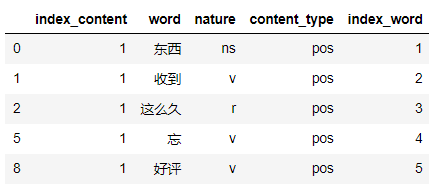

In [9]:
# seg_content:word flag Series
# n_word count line Series
# n_content [各分词在第几条评论] list
# index_content_long 各分词在第几条评论 list
# seg_content_long 词及词性，去掉[] list
# word_long list
# nature_long list
# content_type_long pos neg

In [12]:
#分词，由元组组成的list
# import jieba.posseg as psg
seg_content=content.apply( lambda s:  [(x.word,x.flag) for x in psg.cut(s)] )  
seg_content.shape  #词和词性
len(seg_content)
print(seg_content[5])

(3350,)

3350

[('功率', 'n'), ('大小', 'b'), ('：', 'x'), ('使用方便', 'l'), ('，', 'x'), ('一级', 'm'), ('能效', 'n'), ('，', 'x'), ('功能齐全', 'i'), ('，', 'x'), ('外观', 'n'), ('漂亮', 'a'), ('，', 'x'), ('特别', 'd'), ('是', 'v'), ('那个', 'r'), ('金色', 'n'), ('弧度', 'n'), ('，', 'x'), ('犹如', 'v'), ('财源滚滚', 'n'), ('来', 'v'), ('，', 'x'), ('看着', 'v'), ('也', 'd'), ('开心', 'v'), ('。', 'x'), ('客服', 'n'), ('及时', 'c'), ('回', 'v'), ('消息', 'n'), ('。', 'x'), (' ', 'x'), ('安装', 'v'), ('服务', 'vn'), ('：', 'x'), ('送装', 'v'), ('一体', 'n'), ('非常', 'd'), ('方便', 'a'), ('，', 'x'), ('安装', 'v'), ('师傅', 'nr'), ('也', 'd'), ('很', 'd'), ('认真', 'ad'), ('，', 'x'), ('提前', 'v'), ('打电话', 'l'), ('确认', 'v'), ('时间', 'n'), ('，', 'x'), ('临走', 'v'), ('还', 'd'), ('交代', 'n'), ('如', 'v'), ('有', 'v'), ('问题', 'n'), ('联系', 'n'), ('他', 'r'), ('，', 'x'), ('加长', 'v'), ('了', 'ul'), ('管子', 'n'), ('，', 'x'), ('售后', 'n'), ('也', 'd'), ('很', 'd'), ('负责', 'v'), ('，', 'x'), ('及时', 'c'), ('沟通', 'v'), ('回访', 'v'), ('。', 'x'), (' ', 'x'), ('制冷', 'v'), (' ', 'x'), ('热', 'n'), ('效果', '

In [13]:
#统计评论词数
n_word=seg_content.apply(lambda s: len(s))   
len(n_word)
n_word.head(6)

3350

0    48
1    80
2    38
3    63
4    73
5    90
Name: content, dtype: int64

In [15]:
# https://blog.csdn.net/weixin_42575020/article/details/107110585
# del list
#得到各分词在第几条评论
n_content=[ [x+1]*y for x,y in zip(list(seg_content.index),list(n_word))] #[x+1]*y,表示复制y份，由list组成的list
# n_content=[ [x+1]*y for x,y in zip(seg_content.index.to_list(),n_word.to_list())] [1,1,1,1,2,2,2,2,3,3,3...]
index_content_long=sum(n_content,[]) #表示去掉[]，拉平,返回list 
len(index_content_long)

58008

In [16]:
sum([[2,2],[3,3,3]],[])

[2, 2, 3, 3, 3]

In [17]:
#分词及词性，去掉[]，拉平
seg_content.head()
seg_content_long=sum(seg_content,[])
seg_content_long  
len(seg_content_long)

0    [(家里, s), (一直, d), (都, d), (是, v), (买, v), (的,...
1    [(家里, s), (一共, j), (买, v), (了, ul), (四台, m), (...
2    [(送货, v), (小哥, n), (服务到位, n), (，, x), (大热天, n)...
3    [(功率, n), (大小, b), (：, x), (目前, t), (还, d), (没...
4    [(制冷, v), (效果, n), (非常, d), (棒, zg), (，, x), (...
Name: content, dtype: object

[('家里', 's'),
 ('一直', 'd'),
 ('都', 'd'),
 ('是', 'v'),
 ('买', 'v'),
 ('的', 'uj'),
 ('，', 'x'),
 ('质量', 'n'),
 ('有', 'v'),
 ('保障', 'v'),
 ('，', 'x'),
 ('外观', 'n'),
 ('好看', 'v'),
 ('，', 'x'),
 ('安装', 'v'),
 ('服务', 'vn'),
 ('好', 'a'),
 ('，', 'x'),
 ('细心', 'n'),
 ('想', 'v'),
 ('办法', 'n'),
 ('解决问题', 'n'),
 ('，', 'x'),
 ('为', 'p'),
 ('客户', 'n'),
 ('着想', 'v'),
 ('，', 'x'),
 ('提供', 'v'),
 ('了', 'ul'),
 ('最佳', 'z'),
 ('技术', 'n'),
 ('。', 'x'),
 ('安装', 'v'),
 ('后', 'f'),
 ('试了试', 'v'),
 ('机器', 'n'),
 ('，', 'x'),
 ('效果', 'n'),
 ('还是', 'c'),
 ('跟', 'p'),
 ('以前', 'f'),
 ('一样', 'r'),
 ('，', 'x'),
 ('很快', 'd'),
 ('温度', 'n'),
 ('就', 'd'),
 ('降下来', 'v'),
 ('。', 'x'),
 ('家里', 's'),
 ('一共', 'j'),
 ('买', 'v'),
 ('了', 'ul'),
 ('四台', 'm'),
 ('的', 'uj'),
 ('，', 'x'),
 ('效果', 'n'),
 ('不错', 'a'),
 ('，', 'x'),
 ('制冷', 'v'),
 ('很快', 'd'),
 ('，', 'x'),
 ('运行', 'v'),
 ('声音', 'n'),
 ('也', 'd'),
 ('不大', 'a'),
 ('。', 'x'),
 ('可以', 'c'),
 ('手机', 'n'),
 ('操控', 'v'),
 ('，', 'x'),
 ('不用', 'v'),
 ('遥控器', 'n'),
 ('，', 'x'),


58008

In [18]:
#得到加长版的分词、词性 词和词性分离
word_long=[x[0] for x in seg_content_long]  #词
nature_long=[x[1] for x in seg_content_long]  #词性

len(word_long)
len(nature_long)

58008

58008

In [19]:
#content_type拉长
n_content_type=[ [x]*y for x,y in zip(list(reviews['content_type']),list(n_word))] #[x+1]*y,表示复制y份
content_type_long=sum(n_content_type,[]) #表示去掉[]，拉平
len(content_type_long)    #content_type拉长

58008

In [20]:
review_long=pd.DataFrame({'index_content':index_content_long,
                        'word':word_long,
                        'nature':nature_long,
                        'content_type':content_type_long})   #合并成一个DataFrame
review_long.shape
review_long.head()

(58008, 4)

,index_content,word,nature,content_type
0,1,家里,s,pos
1,1,一直,d,pos
2,1,都,d,pos
3,1,是,v,pos
4,1,买,v,pos


（2）去除标点符号、去除停用词

In [21]:
review_long['nature'].unique()

array(['s', 'd', 'v', 'uj', 'x', 'n', 'vn', 'a', 'p', 'ul', 'z', 'f', 'c',
       'r', 'j', 'm', 'nr', 'k', 't', 'u', 'zg', 'l', 'ug', 'i', 'e',
       'nz', 'b', 'y', 'ad', 'nrt', 'ud', 'ns', 'tg', 'uz', 'q', 'an',
       'nt', 'uv', 'rz', 'o', 'df', 'mq', 'ng', 'vg', 'nrfg', 'g', 'h',
       'yg', 'vd'], dtype=object)

In [22]:
#去除标点符号
review_long_clean=review_long[review_long['nature']!='x'] #x表示标点符合
review_long_clean.shape

(45447, 4)

In [23]:
#导入停用词
stop_path=open('G:\\work\\testdata\\stoplist.txt','r',encoding='UTF-8')
stop_words=stop_path.readlines()

len(stop_words)
stop_words[0:5]

5748

['\ufeff \n', '说\n', '人\n', '元\n', 'hellip\n']

In [24]:
#停用词，预处理
stop_words=[word.strip('\n') for word in stop_words]
stop_words[0:5]  

['\ufeff ', '说', '人', '元', 'hellip']

In [25]:
#得到不含停用词的分词表
word_long_clean=list(set(word_long)-set(stop_words))  #差集 - : x-y，返回一个新的集合,包括在集合 x 中但不在集合 y 中的元素。 
len(word_long_clean)

review_long_clean=review_long_clean[review_long_clean['word'].isin(word_long_clean)]
review_long_clean.shape

3031

(26788, 4)

(3)在原df中，再增加一列，该分词在本条评论的位置

In [26]:
#再次统计每条评论的分词数量
n_word=review_long_clean.groupby('index_content').count()['word']
n_word
index_word=[ list(np.arange(1,x+1)) for x in list(n_word)] # 1, 2, 3, 4, 5, 6, 7, 8, 9
index_word_long=sum(index_word,[]) #表示去掉[]，拉平
len(index_word_long)

index_content
1       23
2       32
3       22
4       23
5       29
        ..
3346     4
3347     5
3348     5
3349    16
3350    30
Name: word, Length: 3311, dtype: int64

26788

In [27]:
review_long_clean['index_word']=index_word_long   #加一列index_word存
review_long_clean.head()

,index_content,word,nature,content_type,index_word
0,1,家里,s,pos,1
7,1,质量,n,pos,2
9,1,保障,v,pos,3
11,1,外观,n,pos,4
12,1,好看,v,pos,5


In [28]:
review_long_clean.to_csv('G:\\work\\testdata\\1_review_long_clean.csv')

In [29]:
print(review_long_clean)

       index_content  word nature content_type  index_word
0                  1    家里      s          pos           1
7                  1    质量      n          pos           2
9                  1    保障      v          pos           3
11                 1    外观      n          pos           4
12                 1    好看      v          pos           5
...              ...   ...    ...          ...         ...
57997           3350    希望      v          pos          26
57998           3350   越做越      v          pos          27
58002           3350    顾客     nr          pos          28
58003           3350    提供      v          pos          29
58006           3350  优质产品      n          pos          30

[26788 rows x 5 columns]


(4)提取名词

In [30]:
n_review_long_clean=review_long_clean[[ 'n' in nat for nat in review_long_clean.nature]]
n_review_long_clean.shape
n_review_long_clean.head()

(12123, 5)

,index_content,word,nature,content_type,index_word
7,1,质量,n,pos,2
11,1,外观,n,pos,4
15,1,服务,vn,pos,7
18,1,细心,n,pos,8
20,1,办法,n,pos,10


In [31]:
n_review_long_clean.nature.value_counts()
n_review_long_clean.to_csv('G:\\work\\testdata\\1_n_review_long_clean.csv')

n       8038
vn      2153
nr      1492
ns       212
nz       159
an        23
ng        21
nrt       18
nt         4
nrfg       3
Name: nature, dtype: int64

In [32]:
print(n_review_long_clean)

       index_content  word nature content_type  index_word
7                  1    质量      n          pos           2
11                 1    外观      n          pos           4
15                 1    服务     vn          pos           7
18                 1    细心      n          pos           8
20                 1    办法      n          pos          10
...              ...   ...    ...          ...         ...
57986           3350    电器      n          pos          21
57992           3350   性价比      n          pos          23
57995           3350    国货      n          pos          25
58002           3350    顾客     nr          pos          28
58006           3350  优质产品      n          pos          30

[12123 rows x 5 columns]


（5）词云图

In [33]:
#txt = "life is short, you need python"
#review_long_clean.word.values.dtype
#print("okok+"+review_long_clean.word.values.dtype)
##print("okok+"+review_long_clean.word.values)
#wordcloud.generate(Counter(review_long_clean.word.values))
#wordcloud.generate_from_frequencies(Counter(review_long_clean.word.values))
#wordcloud.to_file('C:\\Users\\huangcong\\Desktop\\202203教案\\分享资料3\\ct.png')

In [34]:
# https://pymongo.readthedocs.io/en/stable/ file:///D:/LOU/MongoDB/mongodb_base.pdf
# https://docs.python.org/zh-cn/3/library/json.html?highlight=json#module-json
# 将DataFrame保存到Mongodb

df_data=review_long_clean
data = json.loads(df_data.T.to_json()).values()
client = pymongo.MongoClient('mongodb://localhost:27017/')
db = client["pytest"]
db.pyreviews.insert_many(data)

In [35]:
1#db.comment.find({userid:"1003"},{userid:1,nickname:1,_id:0})

col_name = db['pyreviews']
df_mongod = pd.DataFrame(list(col_name.find({},{"_id":0})))   
df_mongod.head(10)

1

,index_content,word,nature,content_type,index_word
0,1,家里,s,pos,1
1,1,质量,n,pos,2
2,1,保障,v,pos,3
3,1,外观,n,pos,4
4,1,好看,v,pos,5
5,1,安装,v,pos,6
6,1,服务,vn,pos,7
7,1,细心,n,pos,8
8,1,想,v,pos,9
9,1,办法,n,pos,10


<Figure size 1728x864 with 0 Axes>

(-0.5, 532.5, 490.5, -0.5)

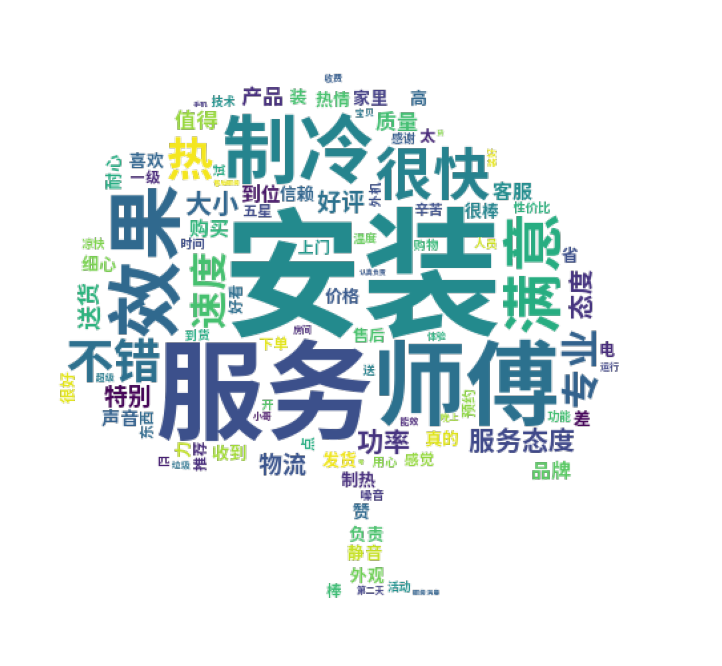

In [62]:
# https://amueller.github.io/word_cloud/references.html
#font=r"C:\Windows\Fonts\msyh.ttc"
font="bb4171.ttf"
#background_image=plt.imread('G:\\work\\testdata\\1.png')
background_image =  np.array(Image.open('G:\\work\\testdata\\tree.jpg'))
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color=None,mask=background_image) 
#wordcloud = WordCloud(font_path=font, max_words = 100, background_color='white',mask=background_image) #width=1600,height=1200, mode='RGBA'
#wordcloud = WordCloud(font_path=None,max_words = 100, background_color='white', mode='RGBA')
#print("okok+"+review_long_clean.word.values)
wordcloud.generate_from_frequencies(Counter(df_mongod.word.values))
wordcloud.to_file('G:\\work\\testdata\\1_分词后的词云图.png')

plt.figure(figsize=(24,12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 1440x720 with 0 Axes>

(-0.5, 639.5, 479.5, -0.5)

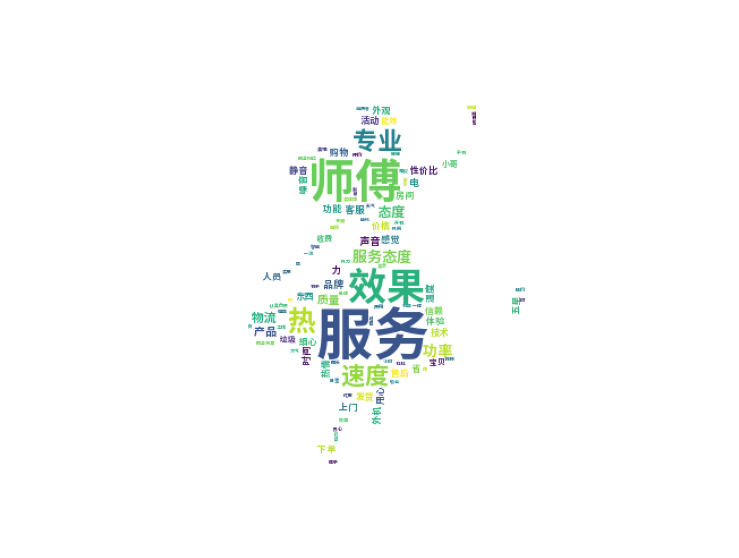

In [63]:
font=r"C:\Windows\Fonts\msyh.ttc"

# background_image=plt.imread('G:\\work\\testdata\\4.png')
font="bb4171.ttf"
background_image =  np.array(Image.open('G:\\work\\testdata\\sphx_glr_masked_002.png'))
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(n_review_long_clean.word.values))
wordcloud.to_file('1_分词后的词云图(名词）.png')

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 三、模型构建

### （一）基于决策树的情感分类

In [64]:
#第一步：构造特征空间和标签

Y=[]
for ind in review_long_clean.index_content.unique():
    y=[ word for word in review_long_clean.content_type[review_long_clean.index_content==ind].unique() ]
    Y.append(y)
len(Y)

X=[]
for ind in review_long_clean.index_content.unique():
    term=[ word for word in review_long_clean.word[review_long_clean.index_content==ind].values ]
    X.append(' '.join(term))
len(X)

X
Y

3311

3311

['家里 质量 保障 外观 好看 安装 服务 细心 想 办法 解决问题 客户 着想 提供 最佳 技术 安装 试了试 机器 效果 很快 温度 降下来',
 '家里 一共 四台 效果 不错 制冷 很快 运行 声音 手机 操控 不用 遥控器 家里 小宝宝 喜欢 乱 遥控器 好多 安装 师傅 晚上 安装 验收 调试 走 负责 三个 月 上门服务 耗电 细算',
 '送货 小哥 服务到位 大热天 提前 电话 预约 准时 送达 一口气 背上 楼 服务 哇塞 美观 上档次 制冷 效果 风力 强劲 要买 选',
 '功率 大小 长时间 期待 样子 好看 金色 字 高大 性价比 安装 服务 安装 预约 师傅 专业 制冷 热 效果 试 凉快 降温 挺快',
 '制冷 效果 棒 几分钟 房间 清凉 关键 一级 能效 太 省 电 机子 噪音 安装 师傅 不错 服务 很好 满意 购物 品牌 几年 十几年 信任 品牌 购买 客服 服务',
 '功率 大小 使用方便 一级 能效 功能齐全 外观 漂亮 特别 金色 弧度 犹如 财源滚滚 看着 开心 客服 回 消息 安装 服务 送装 一体 安装 师傅 提前 打电话 确认 时间 临走 交代 加长 管子 售后 负责 沟通 回访 制冷 热 效果 制冷 制热 冬天 试',
 '安装 师傅 安装 垃圾 弄 装 仔细 制冷 很快 家里 洗衣机 品牌 值得 信赖',
 '确实 不错 声音 很小 冷 速度 很快 安装 师傅 力 小时 装好',
 '收到 物流 很快 外包装 破损 安装 师傅 服务 安装 建议 周到 不错 购物 体验',
 '安装 服务 师傅 热情 专业 服务态度 制冷 热 效果 制冷 款式 精美 优惠 力度',
 '安装 服务 安装 师傅 安装 仔细 制冷 热 效果 制冷 效果 很快 静音 噪音',
 '师傅 送货上门 安装 热情 专业 服务 制冷 效果',
 '制冷 热 效果 制冷 凉爽 防直 吹 静音 噪音 特别 颜值 高 晚上 关灯 显示 温度 灯光 自动 熄灭 奈斯 放在 卧室 里 静音 防直 吹 关键 性价比 高 安装 到位',
 '冷 师傅 安装 不错 满意 制冷 热 效果 冷',
 '安装 服务 师傅',
 '功率 大小 描述 相符合 安装 服务 预约 安装 师傅 上门 安装 服务 收费 透明 额外 收费 制冷 热 效果 夏天 制冷 制

[['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['neg'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['neg'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['neg'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],
 ['pos'],


In [68]:
# from sklearn import tree
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score
# from sklearn.datasets import load_iris


#第二步：训练集、测试集划分
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=7) #

#第三步：词转向量，01矩阵
count_vec=CountVectorizer(binary=True)  # Convert a collection of text documents to a matrix of token counts. If True, all non zero counts are set to 1  从文本内容中提取数字特征 将文本文档集合转换为数字特征向量的一般过程 
x_train=count_vec.fit_transform(x_train)
x_test=count_vec.transform(x_test)  

#第四步：构建决策树
dtc=tree.DecisionTreeClassifier(max_depth=5)
dtc = dtc.fit(x_train,y_train)
print('在训练集上的准确率：%.2f'% accuracy_score(y_train,dtc.predict(x_train)))

y_true=y_test
y_pred=dtc.predict(x_test)
print(classification_report(y_true,y_pred))
print('在测试集上的准确率：%.2f'% accuracy_score(y_true,y_pred))

在训练集上的准确率：0.94
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00        41
         pos       0.94      1.00      0.97       622

    accuracy                           0.94       663
   macro avg       0.47      0.50      0.48       663
weighted avg       0.88      0.94      0.91       663

在测试集上的准确率：0.94


<Figure size 1728x864 with 0 Axes>

[Text(925.6235294117647, 597.96, 'X[610] <= 0.5\ngini = 0.126\nsamples = 2648\nvalue = [179, 2469]'),
 Text(669.6, 489.24, 'X[1381] <= 0.5\ngini = 0.123\nsamples = 2641\nvalue = [174, 2467]'),
 Text(393.88235294117646, 380.52000000000004, 'X[14] <= 0.5\ngini = 0.169\nsamples = 1378\nvalue = [128, 1250]'),
 Text(236.3294117647059, 271.8, 'X[1796] <= 0.5\ngini = 0.165\nsamples = 1374\nvalue = [125, 1249]'),
 Text(157.5529411764706, 163.07999999999998, 'X[1437] <= 0.5\ngini = 0.163\nsamples = 1372\nvalue = [123, 1249]'),
 Text(78.7764705882353, 54.360000000000014, 'gini = 0.158\nsamples = 1360\nvalue = [118, 1242]'),
 Text(236.3294117647059, 54.360000000000014, 'gini = 0.486\nsamples = 12\nvalue = [5, 7]'),
 Text(315.1058823529412, 163.07999999999998, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(551.4352941176471, 271.8, 'X[129] <= 0.5\ngini = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(472.6588235294118, 163.07999999999998, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(630.21176

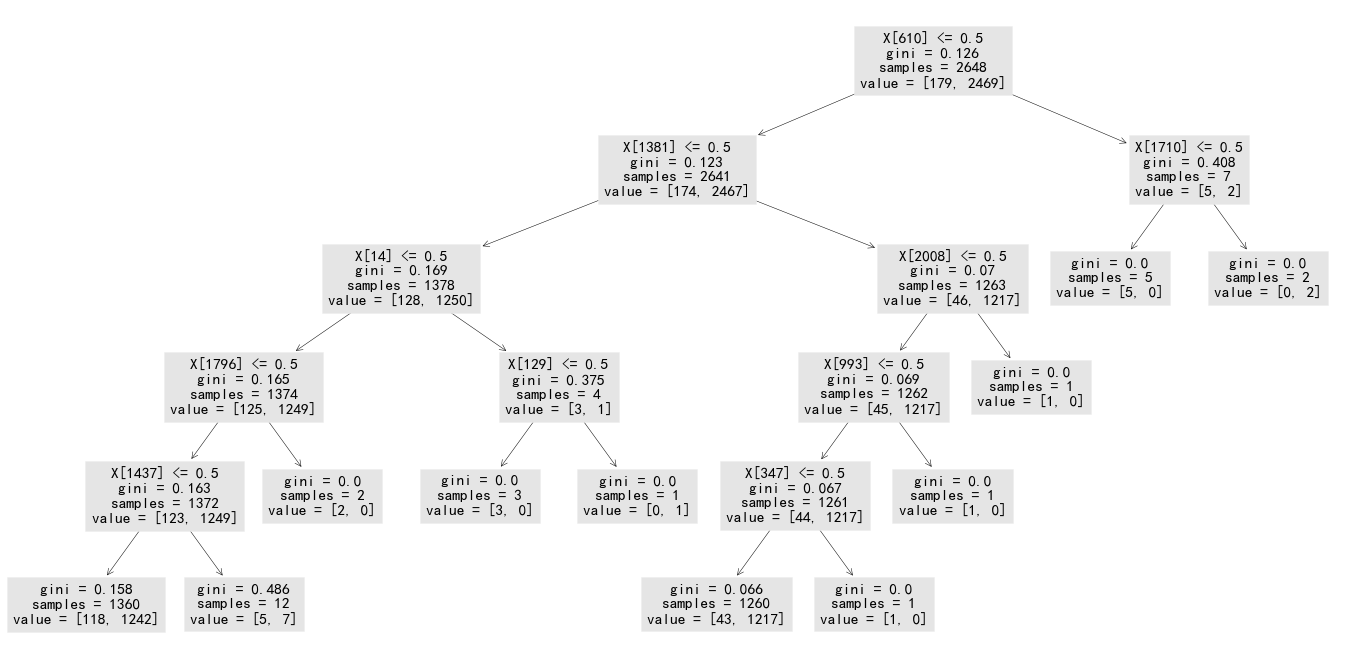

In [69]:
plt.figure(figsize=(24,12))
tree.plot_tree(dtc)
plt.show()

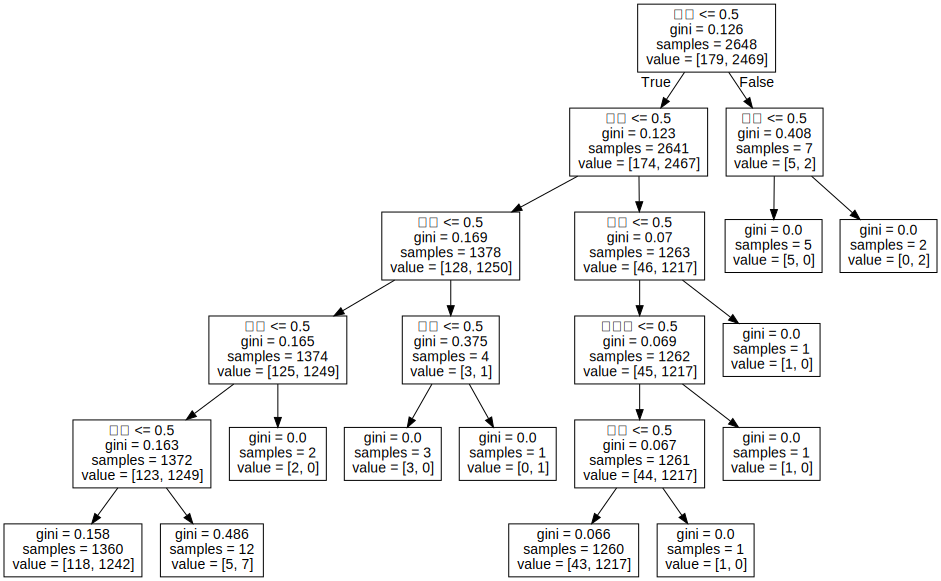

In [70]:
#第五步：画决策树
#这个决策数图，需要在网上下载graphviz  包，并且配置环境变量
from graphviz import Digraph
import os
#C:\\Program Files\\Graphviz\\bin
#C:\\Users\\huangcong\\Desktop\\202203教案\\分享资料3\\1.png
# os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'  $os.environ["PATH"] += os.pathsep + 'G:\WEB\Graphviz\bin/'
dot_data=tree.export_graphviz(dtc ,feature_names=count_vec.get_feature_names())
graph=graphviz.Source(dot_data)
graph

### （二）情感分析

数据预处理的思路与目标

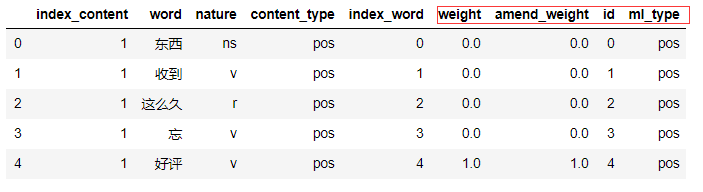

(1)导入评价情感词

In [71]:
#来自知网发布的情感分析用词语集
#raw_data=pd.read_csv('C:\\Users\\huangcong\\Desktop\\202203教案\\分享资料3\\reviews.csv')   注意各路径 \ /
#务必这种写法'C:\\Users\\huangcong\\Desktop\\202203教案\\分享资料3\\正面评价词语（中文）.txt',header=None,sep='/n',engine='python'
pos_comment=pd.read_csv('G:\\work\\testdata\\正面评价词语（中文）.txt',header=None,sep='/n',engine='python') 
neg_comment=pd.read_csv('G:\\work\\testdata\\负面评价词语（中文）.txt',header=None,sep='/n',engine='python')

pos_emotion=pd.read_csv('G:\\work\\testdata\\正面情感词语（中文）.txt',header=None,sep='/n',engine='python')
neg_emotion=pd.read_csv('G:\\work\\testdata\\负面情感词语（中文）.txt',header=None,sep='/n',engine='python')

In [72]:
pos_comment.shape
neg_comment.shape

pos_emotion.shape
neg_emotion.shape

(3743, 1)

(3138, 1)

(833, 1)

(1251, 1)

In [73]:
pos=pd.concat([pos_comment,pos_emotion],axis=0)  #axis{0/’index’, 1/’columns’}, default 0
pos.shape

neg=pd.concat([neg_comment,neg_emotion],axis=0)
neg.shape

(4576, 1)

(4389, 1)

(2)增加新词

In [74]:
c='点赞'
c in pos.values

d='歇菜'
d in neg.values

False

False

In [75]:
new_pos=pd.Series(['点赞'])
new_neg=pd.Series(['歇菜'])
positive=pd.concat([pos,new_pos],axis=0)
positive.shape

negative=pd.concat([neg,new_neg],axis=0)
negative.shape

(4577, 1)

(4390, 1)

In [76]:
positive.columns=['review']
positive['weight']=pd.Series([1]*len(positive))
positive.head()

,review,weight
0,侻,1
1,俶傥,1
2,僄,1
3,劼,1
4,嫕,1


In [77]:
negative.columns=['review']
negative['weight']=pd.Series([-1]*len(negative))
negative.head()

,review,weight
0,僄,-1
1,啰啰唆唆,-1
2,啰啰嗦嗦,-1
3,啰里啰唆,-1
4,啰里啰嗦,-1


In [78]:
pos_neg=pd.concat([positive,negative],axis=0)
pos_neg.shape

(8967, 2)

(3)合并到review_long_clean中

In [79]:
#表联接
data=review_long_clean.copy()
review_mltype=pd.merge(data,pos_neg,how='left',left_on='word',right_on='review')  #left join word和review匹配
review_mltype.shape

review_mltype=review_mltype.drop(['review'],axis=1)
review_mltype=review_mltype.replace(np.nan,0)
review_mltype.head()

(27767, 7)

,index_content,word,nature,content_type,index_word,weight
0,1,家里,s,pos,1,0.0
1,1,质量,n,pos,2,0.0
2,1,保障,v,pos,3,0.0
3,1,外观,n,pos,4,0.0
4,1,好看,v,pos,5,1.0


(4)修正情感倾向，

如有多重否定，那么奇数否定是否定，偶数否定是肯定

看该情感词前2个词，来判罚否定的语气。如果在句首，则没有否词，如果在句子的第二次词，则看前1个词，来判断否定的语气。

In [80]:
notdict=pd.read_csv('G:\\work\\testdata\\not.csv')
notdict.shape
notdict['freq']=[1]*len(notdict)  #加一列freq
notdict.head()

(21, 1)

,term,freq
0,不,1
1,没,1
2,无,1
3,非,1
4,莫,1


In [81]:
#准备一
review_mltype['amend_weight']=review_mltype['weight']
review_mltype['id']=np.arange(0,review_mltype.shape[0])
review_mltype

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,家里,s,pos,1,0.0,0.0,0
1,1,质量,n,pos,2,0.0,0.0,1
2,1,保障,v,pos,3,0.0,0.0,2
3,1,外观,n,pos,4,0.0,0.0,3
4,1,好看,v,pos,5,1.0,1.0,4
...,...,...,...,...,...,...,...,...
27762,3350,希望,v,pos,26,1.0,1.0,27762
27763,3350,越做越,v,pos,27,0.0,0.0,27763
27764,3350,顾客,nr,pos,28,0.0,0.0,27764
27765,3350,提供,v,pos,29,0.0,0.0,27765


In [82]:
# 准备二，只保留有情感值的行
only_review_mltype=review_mltype[review_mltype['weight']!=0]
only_review_mltype.index=np.arange(0,only_review_mltype.shape[0]) #索引重置 reset_index()
only_review_mltype

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,好看,v,pos,5,1.0,1.0,4
1,1,细心,n,pos,8,1.0,1.0,7
2,1,想,v,pos,9,1.0,1.0,8
3,1,着想,v,pos,13,1.0,1.0,12
4,1,最佳,z,pos,15,1.0,1.0,14
...,...,...,...,...,...,...,...,...
5887,3350,一级,m,pos,18,1.0,1.0,27753
5888,3350,棒,zg,pos,19,1.0,1.0,27754
5889,3350,高,a,pos,24,1.0,1.0,27759
5890,3350,高,a,pos,24,-1.0,-1.0,27760


In [83]:
i=1
review_i=review_mltype[review_mltype['index_content']==only_review_mltype['index_content'][i]]
review_i#第i个情感词的评论

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,家里,s,pos,1,0.0,0.0,0
1,1,质量,n,pos,2,0.0,0.0,1
2,1,保障,v,pos,3,0.0,0.0,2
3,1,外观,n,pos,4,0.0,0.0,3
4,1,好看,v,pos,5,1.0,1.0,4
5,1,安装,v,pos,6,0.0,0.0,5
6,1,服务,vn,pos,7,0.0,0.0,6
7,1,细心,n,pos,8,1.0,1.0,7
8,1,想,v,pos,9,1.0,1.0,8
9,1,办法,n,pos,10,0.0,0.0,9


In [84]:
only_review_mltype

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,好看,v,pos,5,1.0,1.0,4
1,1,细心,n,pos,8,1.0,1.0,7
2,1,想,v,pos,9,1.0,1.0,8
3,1,着想,v,pos,13,1.0,1.0,12
4,1,最佳,z,pos,15,1.0,1.0,14
...,...,...,...,...,...,...,...,...
5887,3350,一级,m,pos,18,1.0,1.0,27753
5888,3350,棒,zg,pos,19,1.0,1.0,27754
5889,3350,高,a,pos,24,1.0,1.0,27759
5890,3350,高,a,pos,24,-1.0,-1.0,27760


In [88]:
#看该情感词前2个词，来判罚否定的语气。如果在句首，则没有否词，如果在句子的第二次词，则看前1个词，来判断否定的语气。

index=only_review_mltype['id']

for i in range(0,only_review_mltype.shape[0]):
    
    review_i=review_mltype[review_mltype['index_content']==only_review_mltype['index_content'][i]] #第i个情感词的评论
    review_i.index=np.arange(0,review_i.shape[0])#重置索引后，索引值等价于index_word X
    word_ind = only_review_mltype['index_word'][i] #第i个情感值在该条评论的位置
    
    #第一种，在句首。则不用判断
    #第二种，在评论的第2个为位置
    if word_ind==2:
        ne=sum( [ review_i['word'][word_ind-1] in notdict['term']  ] )
        if ne==1:
            review_mltype['amend_weight'][index[i]] = -( review_mltype['weight'][index[i]] ) #index(id)映射真实位置
    #第三种，在评论的第2个位置以后       
    elif word_ind > 2:
        ne=sum( [ word in notdict['term'] for word in review_i['word'][[word_ind-1,word_ind-2]]  ] ) # 注意用中括号[word_ind-1,word_ind-2]
        if ne==1:                                                                                     # 一个否定
            review_mltype['amend_weight'][index[i]]=- ( review_mltype['weight'][index[i]] )

In [89]:
review_mltype.shape
review_mltype[(review_mltype['weight']-review_mltype['amend_weight'])!=0] #说明两列值一样 

(27767, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,id


(5)计算每条评论的情感值

In [90]:
review_mltype.tail()

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
27762,3350,希望,v,pos,26,1.0,1.0,27762
27763,3350,越做越,v,pos,27,0.0,0.0,27763
27764,3350,顾客,nr,pos,28,0.0,0.0,27764
27765,3350,提供,v,pos,29,0.0,0.0,27765
27766,3350,优质产品,n,pos,30,0.0,0.0,27766


In [91]:
emotion_value=review_mltype.groupby('index_content',as_index=False)['amend_weight'].sum()  #as_index=False is effectively “SQL-style” grouped output.True返回以'index_content'为索引的对象
emotion_value.head()
emotion_value.to_csv('./1_emotion_value.csv',index=True,header=True)
emotion_value.to_csv('G:\\work\\testdata\\emotion_one.csv',index=False)

,index_content,amend_weight
0,1,6.0
1,2,3.0
2,3,2.0
3,4,5.0
4,5,6.0


(6)查看情感分析效果

In [92]:
#每条评论的amend_weight总和不等于零

content_emotion_value=emotion_value.copy()
content_emotion_value.shape
content_emotion_value=content_emotion_value[content_emotion_value['amend_weight']!=0]
content_emotion_value['ml_type']=''
content_emotion_value['ml_type'][content_emotion_value['amend_weight']>0]='pos'
content_emotion_value['ml_type'][content_emotion_value['amend_weight']<0]='neg'

content_emotion_value.shape
content_emotion_value.head()
# content_emotion_value.to_csv('G:\\work\\testdata\\emotion_one.csv',index=False)

(3311, 2)

(2169, 3)

,index_content,amend_weight,ml_type
0,1,6.0,pos
1,2,3.0,pos
2,3,2.0,pos
3,4,5.0,pos
4,5,6.0,pos


In [93]:
#存每条评论的amend_weight总和等于零
#这个方法其实不好用，有一半以上的评论区分不出正、负情感。

content_emotion_value0=emotion_value.copy()
content_emotion_value0=content_emotion_value0[content_emotion_value0['amend_weight']==0]
content_emotion_value0.head()

# raw_data.content[6]
# raw_data.content[7]
# raw_data.content[8]

,index_content,amend_weight
14,15,0.0
19,20,0.0
24,25,0.0
34,35,0.0
36,37,0.0


In [94]:
#合并到大表中

content_emotion_value=content_emotion_value.drop(['amend_weight'],axis=1)
review_mltype.shape
review_mltype=pd.merge(review_mltype,content_emotion_value,how='left',left_on='index_content',right_on='index_content')
review_mltype=review_mltype.drop(['id'],axis=1)
review_mltype.shape
review_mltype.head()
review_mltype.to_csv('./1_review_mltype',index=True,header=True)

(27767, 8)

(27767, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,ml_type
0,1,家里,s,pos,1,0.0,0.0,pos
1,1,质量,n,pos,2,0.0,0.0,pos
2,1,保障,v,pos,3,0.0,0.0,pos
3,1,外观,n,pos,4,0.0,0.0,pos
4,1,好看,v,pos,5,1.0,1.0,pos


In [95]:
cate=['index_content','content_type','ml_type']
data_type=review_mltype[cate].drop_duplicates()

confusion_matrix=pd.crosstab(data_type['content_type'],data_type['ml_type'],margins=True) #Compute a simple cross tabulation of two (or more) factors. By default computes a frequency table of the factors unless an array of values and an aggregation function are passed.
confusion_matrix

ml_type,neg,pos,All
content_type,,,
neg,20,124,144
pos,117,1908,2025
All,137,2032,2169


In [96]:
data=data_type[['content_type','ml_type']]
data=data.dropna(axis=0) #行
print( classification_report(data['content_type'],data['ml_type']) )

              precision    recall  f1-score   support

         neg       0.15      0.14      0.14       144
         pos       0.94      0.94      0.94      2025

    accuracy                           0.89      2169
   macro avg       0.54      0.54      0.54      2169
weighted avg       0.89      0.89      0.89      2169



In [97]:
data.head(50)

,content_type,ml_type
0,pos,pos
23,pos,pos
57,pos,pos
79,pos,pos
102,pos,pos
132,pos,pos
175,pos,pos
189,pos,pos
201,pos,pos
215,pos,pos


(7)制作词云图

- 只看情感词

In [98]:
data=review_mltype.copy()
data=data[data['amend_weight']!=0]

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

<Figure size 1080x504 with 0 Axes>

(-0.5, 733.5, 614.5, -0.5)

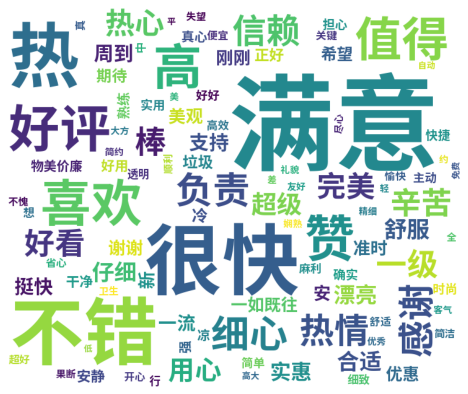

In [99]:
#按照以上修改，显示信息
font="bb4171.ttf"
background_image =  np.array(Image.open('G:\\work\\testdata\\1.png'))

wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
#wordcloud = WordCloud(max_words = 100, mode='RGBA' ,background_color='white') #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_pos.word.values))
wordcloud.to_file('G:\\work\\testdata\\positive_one.png')

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 1080x504 with 0 Axes>

(-0.5, 733.5, 614.5, -0.5)

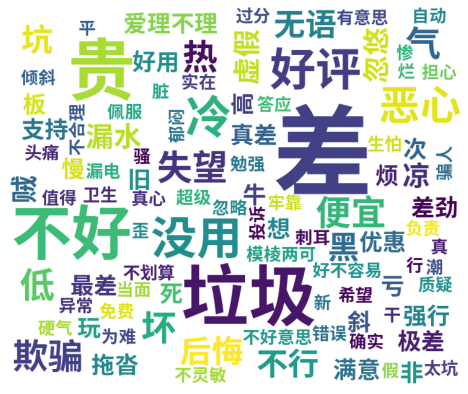

In [100]:
#font=r"C:\Windows\Fonts\msyh.ttc"
font="bb4171.ttf"

background_image =  np.array(Image.open('G:\\work\\testdata\\1.png'))
#background_image=plt.imread('./p6sad.jpg')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
#wordcloud = WordCloud(max_words = 100, mode='RGBA' ,background_color='white') #width=1600,height=1200

wordcloud.generate_from_frequencies(Counter(word_data_neg.word.values))
wordcloud.to_file('G:\\work\\testdata\\negative_one.png')

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- 看所有词

<Figure size 1080x504 with 0 Axes>

(-0.5, 733.5, 614.5, -0.5)

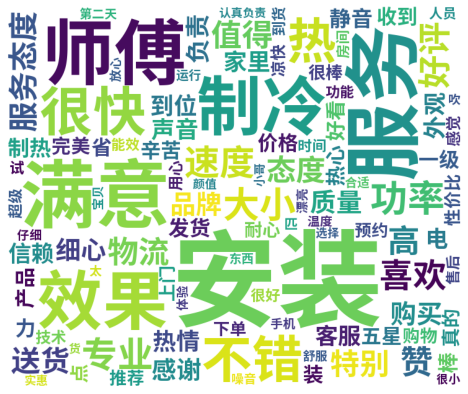

<Figure size 1080x504 with 0 Axes>

(-0.5, 733.5, 614.5, -0.5)

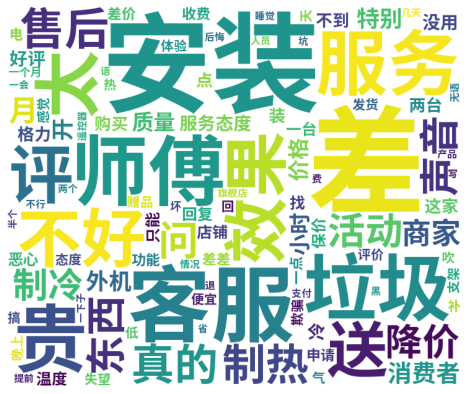

In [101]:
data=review_mltype.copy()

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

font="bb4171.ttf"

background_image=plt.imread('G:\\work\\testdata\\1.png')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_pos.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

background_image=plt.imread('G:\\work\\testdata\\1.png')
wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white',mask=background_image) #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_neg.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### （三）基于LDA模型的主题分析

优点：不需要人工调试，用相对少的迭代找到最优的主题结构。

（1）建立词典、语料库

In [253]:
data=review_mltype.copy()

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']
# word_data_pos=data[data['weight']>0]
# word_data_neg=data[data['weight']<0]

In [254]:
#建立词典，去重
pos_dict=corpora.Dictionary([ [i] for i in word_data_pos.word]) #shape=(n,1)
neg_dict=corpora.Dictionary([ [i] for i in word_data_neg.word])

In [255]:
# #建立语料库
# pos_corpus=[ pos_dict.doc2bow(j) for j in [ [i] for i in word_data_pos.word] ] #shape=(n,(2,1)) 
# neg_corpus=[ neg_dict.doc2bow(j) for j in [ [i] for i in word_data_neg.word] ]
pos_corpus=[ [x] for x in pos_dict.doc2bow(word_data_pos.word.to_list())]
neg_corpus=[ [x] for x in neg_dict.doc2bow(word_data_neg.word.to_list())]



In [256]:
# def Delist(corpus):
#     temp = corpus
#     for i in temp:
#         if i[0][1] < 3:
#             corpus.remove(i)
#     print("success")
#     return corpus
# one = Delist(pos_corpus)       

(2)主题数寻优


In [257]:
#构造主题数寻优函数

def cos(vector1,vector2):
    '''
    函数功能：余玄相似度函数
    '''
    dot_product=0.0
    normA=0.0
    normB=0.0
    for a,b in zip(vector1,vector2):
        dot_product +=a*b
        normA +=a**2
        normB +=b**2
    if normA==0.0 or normB==0.0:
        return None
    else:
        return ( dot_product/((normA*normB)**0.5) )

In [258]:
# import pyLDAvis
# import pyLDAvis.gensim_models  as gensimvis
# import numpy as np
#主题数寻优
#这个函数可以重复调用，解决其他项目的问题
#初始化平均余玄相似度
mean_similarity=[]
mean_similarity.append(1)    
#循环生成主题并计算主题间相似度
for i in np.arange(2,11):
    lda=models.LdaModel(pos_corpus,num_topics=i,id2word=pos_dict) #LDA模型训练 
        
    for j in np.arange(i):
        term=lda.show_topics(num_words=50)
        
    #提取各主题词
    top_word=[] #shape=(i,50)
    for k in np.arange(i):
        top_word.append( [''.join(re.findall('"(.*)"',i)) for i in term[k][1].split('+')]) #列出所有词
        
    #构造词频向量
    word=sum(top_word,[]) #列车所有词
    unique_word=set(word) #去重
        
    #构造主题词列表，行表示主题号，列表示各主题词
    mat=[] #shape=(i,len(unique_word))
    for j in np.arange(i):
        top_w=top_word[j]
        mat.append( tuple([ top_w.count(k) for k in unique_word ])) #统计list中元素的频次，返回元组
        
    #两两组合。方法一
    p=list(itertools.permutations(list(np.arange(i)),2)) #返回可迭代对象的所有数学全排列方式。
    y=len(p) # y=i*(i-1)
    top_similarity=[0]
    for w in np.arange(y):
        vector1=mat[p[w][0]]
        vector2=mat[p[w][1]]
        top_similarity.append(cos(vector1,vector2))

#        #两两组合，方法二
#        for x in range(i-1):
#            for y in range(x,i):
            
        #计算平均余玄相似度
    mean_similarity.append(sum(top_similarity)/ y)
pos_k=mean_similarity
d=gensimvis.prepare(lda,pos_corpus,pos_dict)
pyLDAvis.display(d)

In [259]:
mean_similarity=[]
mean_similarity.append(1)    
#循环生成主题并计算主题间相似度
for i in np.arange(2,11):
    lda=models.LdaModel(neg_corpus,num_topics=i,id2word=neg_dict) #LDA模型训练 
        
    for j in np.arange(i):
        term=lda.show_topics(num_words=50)
        
    #提取各主题词
    top_word=[] #shape=(i,50)
    for k in np.arange(i):
        top_word.append( [''.join(re.findall('"(.*)"',i)) for i in term[k][1].split('+')]) #列出所有词
        
    #构造词频向量
    word=sum(top_word,[]) #列车所有词
    unique_word=set(word) #去重
        
    #构造主题词列表，行表示主题号，列表示各主题词
    mat=[] #shape=(i,len(unique_word))
    for j in np.arange(i):
        top_w=top_word[j]
        mat.append( tuple([ top_w.count(k) for k in unique_word ])) #统计list中元素的频次，返回元组
        
    #两两组合。方法一
    p=list(itertools.permutations(list(np.arange(i)),2)) #返回可迭代对象的所有数学全排列方式。
    y=len(p) # y=i*(i-1)
    top_similarity=[0]
    for w in np.arange(y):
        vector1=mat[p[w][0]]
        vector2=mat[p[w][1]]
        top_similarity.append(cos(vector1,vector2))

#        #两两组合，方法二
#        for x in range(i-1):
#            for y in range(x,i):
            
        #计算平均余玄相似度
    mean_similarity.append(sum(top_similarity)/ y)
neg_k=mean_similarity
d=gensimvis.prepare(lda,neg_corpus,neg_dict)
pyLDAvis.display(d)

<AxesSubplot:>

Text(0.5, 1.0, '正面评论LDA主题数寻优')

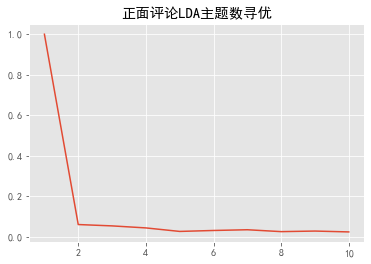

In [260]:
pd.Series(pos_k,index=range(1,11)).plot()
plt.title('正面评论LDA主题数寻优')
plt.show()

<AxesSubplot:>

Text(0.5, 1.0, '负面评论LDA主题数寻优')

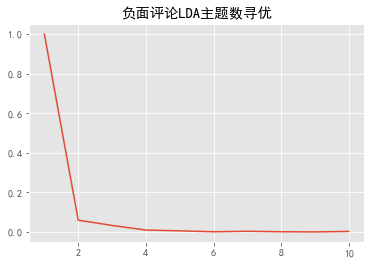

In [261]:
pd.Series(neg_k,index=range(1,11)).plot()
plt.title('负面评论LDA主题数寻优')
plt.show()

In [262]:
pos_lda=models.LdaModel(pos_corpus,num_topics=2,id2word=pos_dict)
neg_lda=models.LdaModel(neg_corpus,num_topics=2,id2word=neg_dict)

pos_lda.print_topics(num_topics=10)
neg_lda.print_topics(num_topics=10)

[(0,
  '0.139*"安装" + 0.068*"服务" + 0.046*"制冷" + 0.025*"热" + 0.011*"喜欢" + 0.010*"高" + 0.009*"值得" + 0.009*"服务态度" + 0.008*"送货" + 0.007*"特别"'),
 (1,
  '0.061*"满意" + 0.056*"师傅" + 0.045*"效果" + 0.029*"很快" + 0.026*"不错" + 0.013*"功率" + 0.013*"大小" + 0.012*"专业" + 0.012*"速度" + 0.011*"好评"')]

[(0,
  '0.042*"差" + 0.019*"客服" + 0.016*"师傅" + 0.015*"垃圾" + 0.014*"安装" + 0.014*"服务" + 0.012*"效果" + 0.011*"不好" + 0.011*"太" + 0.009*"制热"'),
 (1,
  '0.027*"安装" + 0.019*"贵" + 0.013*"送" + 0.013*"售后" + 0.010*"问" + 0.010*"评" + 0.008*"开" + 0.008*"好评" + 0.007*"点" + 0.007*"装"')]